In [5]:
### Load necessary modules -------------------------------
# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from xgboost import XGBClassifier
import joblib

# others
from funciones_limpieza import *
from utils_aprendizaje_no_supervisado import *
from funciones_clasificacion import *
from funciones_seriestemporales import *

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

import os
os.chdir('/content/drive/MyDrive/RandomForest')

In [3]:
pip install neuralsens

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.4 MB/s eta 0:00:00


In [6]:
#Calcular métricas a partir de matriz acumulada
def resumen_metricas_desde_cm(cm):
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    total = TP + TN + FP + FN
    acc = (TP + TN) / total
    sens = TP / (TP + FN) if (TP + FN) != 0 else 0
    spec = TN / (TN + FP) if (TN + FP) != 0 else 0
    prec = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = sens
    f1 = 2 * (prec * recall) / (prec + recall) if (prec + recall) != 0 else 0
    bal_acc = (sens + spec) / 2

    print(f"Accuracy: {acc:.2f}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"Specificity: {spec:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Balanced Accuracy: {bal_acc:.2f}") #A diferencia del accuracy tradicional, que puede ser engañosamente alto si una clase domina, la balanced accuracy da un peso igual a cada clase, evaluando el desempeño del modelo en cada una por separado y luego promediando.

# Carga de los csvs y preprocesado

In [7]:
# ---------------------
# 1. Definir carpetas
# ---------------------
carpeta_myrtle = "./Join_plots_alarmas"
carpeta_sigma = "./Join_plots_alarmas_Sigma"

# ---------------------
# 2. Obtener lista de CSVs
# ---------------------
archivos = []
for carpeta in [carpeta_myrtle, carpeta_sigma]:
    archivos += [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith(".csv")]

print(f"Total de archivos (inversores): {len(archivos)}")

# ---------------------
# 3. Leer y unir todos
# ---------------------
dfs_global = []
for f in archivos:
    nombre_inversor = os.path.splitext(os.path.basename(f))[0]  # sin extensión
    df = pd.read_csv(f)
    df['FechaHora'] = pd.to_datetime(df['FechaHora'])
    df['inversor_id'] = nombre_inversor
    df['Condensacion'] = df['Condensacion'].astype('category')
    dfs_global.append(df)

df_global = pd.concat(dfs_global, ignore_index=True)

print(f"Shape del DataFrame global: {df_global.shape}")
print(df_global[['inversor_id']].value_counts())  # Ver cuantos registros por inversor


Total de archivos (inversores): 72
Shape del DataFrame global: (3110328, 47)
inversor_id 
10.144.51.1     86398
10.144.51.15    86398
10.144.51.11    43199
10.144.51.12    43199
10.144.51.13    43199
                ...  
10.144.51.72    43199
10.144.51.73    43199
10.144.51.8     43199
10.144.51.9     43199
F1              43199
Name: count, Length: 70, dtype: int64


In [8]:
# Define input and output matrices
variables = df_global.columns.to_list()
INPUTS = [var for var in variables if var != 'Condensacion']
OUTPUT = 'Condensacion'
X = df_global[INPUTS]
y = df_global[OUTPUT]

In [9]:
y_inversores = [] #será una lista de tamaño 72 cada elemento será 1 o 0 dependiendo del valor que tenga la columna 'Condensación'

for f in archivos:
    df = pd.read_csv(f)
    if df['Condensacion'].unique() == 1:
        y_inversores.append(1)
    else:
        y_inversores.append(0)

In [10]:
# ---------------------
# División en train y test por inversor
# ---------------------
archivos_train, archivos_test = train_test_split(archivos,
                                                 test_size=0.2,
                                                 random_state=42,
                                                 stratify = y_inversores) #preserva la distribución de y (proporción de 1 y 0)

dfs_train = []
for f in archivos_train:
    nombre_inversor = os.path.splitext(os.path.basename(f))[0]  # sin extensión
    df = pd.read_csv(f)
    df['FechaHora'] = pd.to_datetime(df['FechaHora'])
    df['inversor_id'] = nombre_inversor
    dfs_train.append(df)

dfs_test = []
for f in archivos_test:
    nombre_inversor = os.path.splitext(os.path.basename(f))[0]  # sin extensión
    df = pd.read_csv(f)
    df['FechaHora'] = pd.to_datetime(df['FechaHora'])
    df['inversor_id'] = nombre_inversor
    dfs_test.append(df)

df_train_total = pd.concat(dfs_train, ignore_index=True)
df_test_total = pd.concat(dfs_test, ignore_index=True)

print("Inversores en train:", len(dfs_train))
print("Inversores en test:", len(dfs_test))
print("Shape train:", df_train_total.shape)
print("Shape test:", df_test_total.shape)

Inversores en train: 57
Inversores en test: 15
Shape train: (2462343, 47)
Shape test: (647985, 47)


In [11]:
#Localizamos los inversores con fallo de condensación tanto en train como test
condensacion_test = []
for archivo in archivos_test:
    nombre_inversor = os.path.splitext(os.path.basename(archivo))[0]
    df_inv = df_test_total[df_test_total['inversor_id'] == nombre_inversor]
    if 1 in df_inv['Condensacion'].values:
        condensacion_test.append(df_inv)
        print(f'El inversor {nombre_inversor} de test ha tenido fallo de condensación')

condensacion_train = []
for archivo in archivos_train:
    nombre_inversor = os.path.splitext(os.path.basename(archivo))[0]
    df_inv = df_train_total[df_train_total['inversor_id'] == nombre_inversor]
    if 1 in df_inv['Condensacion'].values:
        condensacion_train.append(df_inv)
        print(f'El inversor {nombre_inversor} de train ha tenido fallo de condensación')

El inversor 10.144.51.29 de test ha tenido fallo de condensación
El inversor 10.144.51.56 de train ha tenido fallo de condensación
El inversor 10.144.51.1 de train ha tenido fallo de condensación
El inversor 10.144.51.15 de train ha tenido fallo de condensación
El inversor 10.144.51.15 de train ha tenido fallo de condensación
El inversor 10.144.51.1 de train ha tenido fallo de condensación
El inversor 10.144.51.51 de train ha tenido fallo de condensación
El inversor F1 de train ha tenido fallo de condensación


In [12]:
X_train = df_train_total[INPUTS]
y_train = df_train_total[OUTPUT]
X_test = df_test_total[INPUTS]
y_test = df_test_total[OUTPUT]

In [13]:
#ELIMINAR FechaHora (PUES LA INFO HORARIA LA TENGO EN utc)

# Eliminar la columna original
X_train = X_train.drop(columns=['FechaHora'])
X_test = X_test.drop(columns=['FechaHora'])

# Añadir nuevas columnas a INPUTS_DT si las quieres usar
#INPUTS += ['hora', 'minuto']
INPUTS.remove('FechaHora')

# XGBoost con 3 PCA

In [14]:
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])
X_train_num = X_train_num.drop(columns=['sample'])
X_test_num = X_test.select_dtypes(include=['int64', 'float64'])
X_test_num = X_test_num.drop(columns=['sample'])

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

### Información sobre PCA

In [62]:
# Obtener los loadings de cada variable original en cada componente
loadings = pd.DataFrame(
    pca.components_.T,  # transponemos para tener variables como filas
    columns=[f'PCA_{i+1}' for i in range(pca.n_components_)],
    index=X_train_num.columns  # nombres originales de las variables numéricas
)

In [63]:
# Mostrar las 10 variables que más aportan (por valor absoluto del loading) a cada componente
for i in range(pca.n_components_):
    print(f"\n🔹 PCA_{i+1} - Top 10 variables más influyentes:")
    display(
        loadings.iloc[:, i]
        .abs()  # tomamos valor absoluto
        .sort_values(ascending=False)
        .head(10)
    )


🔹 PCA_1 - Top 10 variables más influyentes:


,PCA_1
TBRID12,0.216984
TBRID22,0.215602
TBRID23,0.215526
TBRID21,0.215259
T_SKIIP_MIN,0.214764
TBRID13,0.213866
TBRID11,0.212384
TCOILIND1,0.210634
TCOILIND2,0.208179
IT2_RMS,0.207660



🔹 PCA_2 - Top 10 variables más influyentes:


,PCA_2
TSOC,0.362821
TCAB_POT1,0.362495
TCCU,0.330506
TPOT_CAB_MAX,0.325289
TCAB_POT2,0.288866
TAIR_INLET,0.257088
DELTA_TEMP_AMB,0.239930
UL3_RMS,0.202424
TCOOLINGI,0.192607
TDC_FUSES,0.190930


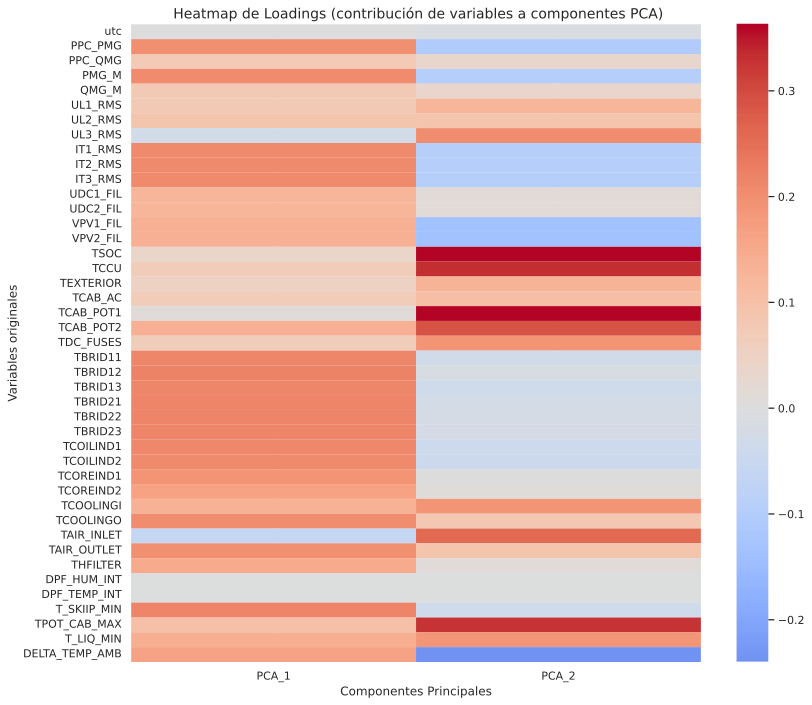

In [64]:
plt.figure(figsize=(12, 10))
sns.heatmap(loadings, cmap='coolwarm', center=0, annot=False)
plt.title(" Heatmap de Loadings (contribución de variables a componentes PCA)", fontsize=14)
plt.xlabel("Componentes Principales")
plt.ylabel("Variables originales")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/RandomForest/XGBoostPCA_HeatMapLoadings.png')
plt.show()

### Entreno  XGBoost

In [16]:
#Vamos a convertir los arrays resultantes de la PCA en un dataframe

X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PCA_{i+1}' for i in range(X_train_pca.shape[1])])
X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PCA_{i+1}' for i in range(X_test_pca.shape[1])])

In [17]:
## Create dataset to store model predictions
dfTR_eval_pca = X_train_pca.copy()
dfTR_eval_pca['Y'] = y_train # We will call Y as output variable for simplicity
dfTS_eval_pca = X_test_pca.copy()
dfTS_eval_pca['Y'] = y_test # We will call Y as output variable for simplicity

In [ ]:
#-------------------------------------------------------------------------------------------------
#---------------------------- XGBOOST MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection

INPUTS_XGB = X_train_pca.columns.to_list()
# Grid de parámetros
param_grid = {
    'xgb__n_estimators': [100, 200], #Número total de árboles (estimadores) que se construyen. Más árboles suelen mejorar el rendimiento pero aumentan el tiempo de entrenamiento y riesgo de overfitting.
    'xgb__max_depth': [3, 5, 7], #Profundidad máxima permitida para cada árbol. Controla la complejidad del árbol.
    'xgb__learning_rate': [0.01, 0.1], #Paso de actualización en cada iteración. Controla cuánto aporta cada árbol.
                                       #Valores bajos hacen el entrenamiento más lento pero a veces mejor generalización.
                                       #Valores altos hacen que aprenda rápido, pero puede sobreajustar.
    'xgb__subsample': [0.8, 1.0], #Proporción de muestras usadas para construir cada árbol (bootstrap sampling). Reduce sobreajuste al usar sólo parte de los datos para cada árbol.
    'xgb__colsample_bytree': [0.8, 1.0] #Proporción de características (columnas) usadas para construir cada árbol. Similar a Random Forest que usa una muestra aleatoria de columnas para diversificar los árboles.
}

# El árbol no realizará una partición en un nodo interno a menos que la reducción en la impureza sea al menos tan grande como este valor.
#Esto significa que para que una partición ocurra en un nodo, la mejora en la entropía debe ser al menos del 2%.
#param = {'DT__min_impurity_decrease': [0.02]} # Minimum entropy to decrease in each split
pipe = Pipeline([('scaler', StandardScaler()),
                 ('xgb', XGBClassifier(tree_method='gpu_hist', #Método de construcción del árbol optimizado para GPU, muy rápido para datasets grandes.
                                       predictor='gpu_predictor', #Indica que las predicciones también se harán usando GPU.
                                       eval_metric='logloss', #Métrica usada para evaluar el error durante el entrenamiento (log loss es la pérdida logarítmica para clasificación)
                                       use_label_encoder=False, #Evita una advertencia por usar un codificador de etiquetas interno que ahora está obsoleto
                                       random_state=150))])



# We use Grid Search ´Cross Validation to find the best parameter for the model in the grid defined
nFolds = 10
# Grid Search con validación cruzada
xgb_fit_pca = GridSearchCV(estimator=pipe,
                       param_grid=param_grid,
                       scoring='recall',
                       cv=nFolds,
                       verbose=1,
                       n_jobs=-1)

xgb_fit_pca.fit(X_train_pca[INPUTS_XGB], y_train) # Search in grid

Fitting 10 folds for each of 48 candidates, totalling 480 fits


In [ ]:
#Guardamos en Drive el grid search
joblib.dump(xgb_fit, '/content/drive/MyDrive/RandomForest/xgb_pca_fit_gridsearch.pkl')
#xgb_fit = joblib.load('/content/drive/MyDrive/RandomForest/xgb4_fit_gridsearch.pkl')


#Guardamos los mejores parámetros
best_params_pca = xgb_fit.best_params_
joblib.dump(best_params, '/content/drive/MyDrive/RandomForest/best_params_pca.pkl')
#Para cargar los parámetros
#best_params = joblib.load('/content/drive/MyDrive/RandomForest/best_params.pkl')
#pipe.set_params(**best_params)
#pipe.fit(X_train, y_train)

In [18]:
mejores_parametros_pca =  {
    'xgb__colsample_bytree': [0.8],
    'xgb__learning_rate': [0.1],
    'xgb__max_depth': [5],
    'xgb__n_estimators': [200],
    'xgb__subsample': [1.0]
}

In [19]:
mejores_parametros_pca

{'xgb__colsample_bytree': [0.8],
 'xgb__learning_rate': [0.1],
 'xgb__max_depth': [5],
 'xgb__n_estimators': [200],
 'xgb__subsample': [1.0]}

In [1]:
!nvidia-smi



Wed Jun 11 11:33:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
#-------------------------------------------------------------------------------------------------
#---------------------------- XGBOOST MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

INPUTS_XGB = X_train_pca.columns.to_list()

# Grid de parámetros
#param_grid = {
#    'xgb__n_estimators': [100, 200], #Número total de árboles (estimadores) que se construyen. Más árboles suelen mejorar el rendimiento pero aumentan el tiempo de entrenamiento y riesgo de overfitting.
#    'xgb__max_depth': [3, 5, 7], #Profundidad máxima permitida para cada árbol. Controla la complejidad del árbol.
#    'xgb__learning_rate': [0.01, 0.1], #Paso de actualización en cada iteración. Controla cuánto aporta cada árbol.
                                       #Valores bajos hacen el entrenamiento más lento pero a veces mejor generalización.
                                       #Valores altos hacen que aprenda rápido, pero puede sobreajustar.
#    'xgb__subsample': [0.8, 1.0], #Proporción de muestras usadas para construir cada árbol (bootstrap sampling). Reduce sobreajuste al usar sólo parte de los datos para cada árbol.
#    'xgb__colsample_bytree': [0.8, 1.0] #Proporción de características (columnas) usadas para construir cada árbol. Similar a Random Forest que usa una muestra aleatoria de columnas para diversificar los árboles.
#}

# El árbol no realizará una partición en un nodo interno a menos que la reducción en la impureza sea al menos tan grande como este valor.
#Esto significa que para que una partición ocurra en un nodo, la mejora en la entropía debe ser al menos del 2%.
param_grid = mejores_parametros_pca
pipe = Pipeline([('scaler', StandardScaler()),
                 ('xgb', XGBClassifier( scale_pos_weight=scale_pos_weight, #Dale más peso a los errores de la clase positiva (la minoritaria), para que el modelo aprenda a detectarla mejor
                                       tree_method='gpu_hist', #Método de construcción del árbol optimizado para GPU, muy rápido para datasets grandes.
                                       predictor='gpu_predictor', #Indica que las predicciones también se harán usando GPU.
                                       eval_metric='logloss', #Métrica usada para evaluar el error durante el entrenamiento (log loss es la pérdida logarítmica para clasificación)
                                       use_label_encoder=False, #Evita una advertencia por usar un codificador de etiquetas interno que ahora está obsoleto
                                       random_state=150))])



# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined
nFolds = 10
# Grid Search con validación cruzada
xgb_fit_pca = GridSearchCV(estimator=pipe,
                       param_grid=param_grid,
                       scoring='recall',
                       cv=nFolds,
                       verbose=1,
                       n_jobs=-1)

xgb_fit_pca.fit(X_train_pca[INPUTS_XGB], y_train) # Search in grid

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:38:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:38:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_t...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor='gpu_predictor', ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.8],
                         'xgb__learning_rate': [0.1], 'xgb__max_depth': [5],
                         'xgb__n_estimators': [200], 'xgb__subsample': [1.0]},
             scoring='recall', verbose=1)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:39:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


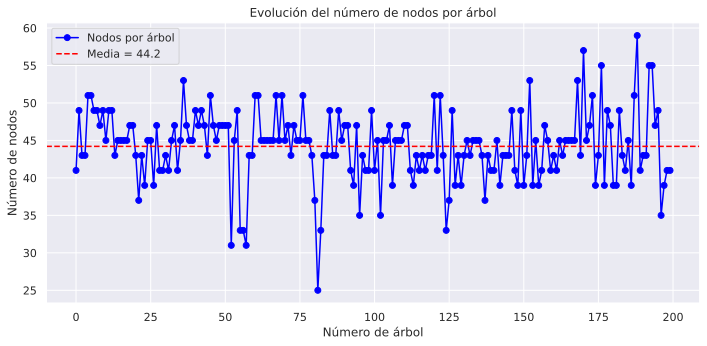

In [21]:
#NÚMERO DE NODOS

booster_pca = xgb_fit_pca.best_estimator_['xgb'].get_booster()

# Obtener DataFrame con todos los árboles
trees_df_pca = booster_pca.trees_to_dataframe()

# Número total de árboles
num_trees_pca = booster_pca.num_boosted_rounds()

# Contar número de nodos por árbol
nodes_per_tree_pca = [
    len(trees_df_pca[trees_df_pca['Tree'] == tree_id])
    for tree_id in range(num_trees_pca)
]

# Calcular la media
mean_nodes_pca = np.mean(nodes_per_tree_pca)

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(range(num_trees_pca), nodes_per_tree_pca, marker='o', label='Nodos por árbol', color='blue')
plt.axhline(mean_nodes_pca, color='red', linestyle='--', label=f'Media = {mean_nodes_pca:.1f}')
plt.xlabel('Número de árbol')
plt.ylabel('Número de nodos')
plt.title('Evolución del número de nodos por árbol')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/RandomForest/XGBoostPCA_NumeroNodosArbol.png')
plt.show()


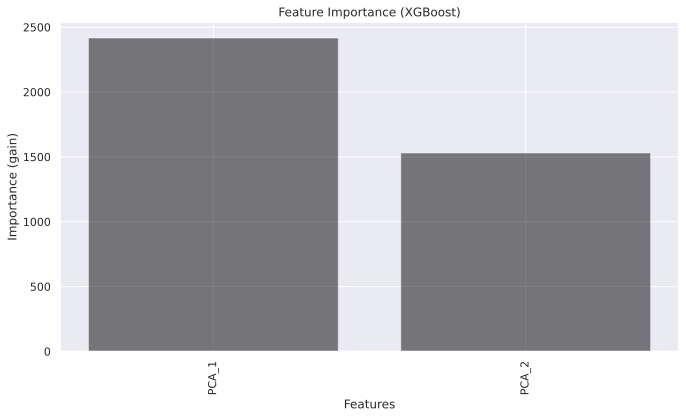

In [22]:
#IMPORTANCIA DE VARIABLES

# Mapping manual de 'f0', 'f1', ... a nombres reales
raw_importance_pca = booster_pca.get_score(importance_type='gain')

# Ordenar por índice f0, f1, ..., convertir a números
sorted_keys_pca = sorted(raw_importance_pca.keys(), key=lambda x: int(x[1:]))
importances_pca = [raw_importance_pca.get(f, 0) for f in sorted_keys_pca]

# Mapear a nombres reales
feature_names_pca = X_train_pca[INPUTS_XGB].columns.tolist()
feature_names_pca = feature_names_pca[:len(importances_pca)]  # por seguridad

# Graficar
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(importances_pca))
plt.bar(index, importances_pca, color='black', alpha=0.5)
plt.xlabel('Features')
plt.ylabel('Importance (gain)')
plt.title('Feature Importance (XGBoost)')
plt.xticks(index, feature_names_pca, rotation=90)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/RandomForest/XGBoostPCA_ImportanciaVariables.png')
plt.show()


In [23]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval_pca['Y_XGB_pred'] = xgb_fit_pca.predict(X_train_pca[INPUTS_XGB])
dfTR_eval_pca['Y_XBG_prob_neg'] = xgb_fit_pca.predict_proba(X_train_pca[INPUTS_XGB])[:,0]
dfTR_eval_pca['Y_XGB_prob_pos'] = xgb_fit_pca.predict_proba(X_train_pca[INPUTS_XGB])[:,1]
### Scale test using preprocess in training
dfTS_eval_pca['Y_XGB_pred'] = xgb_fit_pca.predict(X_test_pca[INPUTS_XGB])
dfTS_eval_pca['Y_XGB_prob_neg'] = xgb_fit_pca.predict_proba(X_test_pca[INPUTS_XGB])[:,0]
dfTS_eval_pca['Y_XGB_prob_pos'] = xgb_fit_pca.predict_proba(X_test_pca[INPUTS_XGB])[:,1]

#visualize evaluated data (TRAIN)
dfTR_eval_pca.head()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:39:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


,PCA_1,PCA_2,Y,Y_XGB_pred,Y_XBG_prob_neg,Y_XGB_prob_pos
0,3.114500,3.089743,0,1,0.249954,0.750046
1,3.123587,3.013803,0,1,0.320543,0.679457
2,3.140585,3.051429,0,1,0.289038,0.710962
3,3.120917,3.024549,0,1,0.320543,0.679457
4,3.124465,3.019877,0,1,0.320543,0.679457


In [24]:
#visualize evaluated data (TEST)
dfTS_eval_pca.head()

,PCA_1,PCA_2,Y,Y_XGB_pred,Y_XGB_prob_neg,Y_XGB_prob_pos
0,2.285967,2.562406,0,1,0.290354,0.709646
1,2.300211,2.630711,0,1,0.288732,0.711268
2,2.301210,2.608455,0,1,0.288732,0.711268
3,2.272184,2.594027,0,1,0.289141,0.710859
4,2.266964,2.639078,0,1,0.300179,0.699821


In [25]:
# Predicciones en train y test
y_train_pred_pca = xgb_fit_pca.predict(X_train_pca[INPUTS_XGB])
y_test_pred_pca = xgb_fit_pca.predict(X_test_pca[INPUTS_XGB])

# Función para calcular specificity (sensibilidad de la clase negativa)
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels = [0,1])
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

# Métricas en train
acc_train = accuracy_score(y_train, y_train_pred_pca)
recall_train = recall_score(y_train, y_train_pred_pca)
#specificity_train = specificity_score(y_train, y_train_pred)
#f1_train = f1_score(y_train, y_train_pred)

# Métricas en test
acc_test = accuracy_score(y_test, y_test_pred_pca)
recall_test = recall_score(y_test, y_test_pred_pca)
#specificity_test = specificity_score(y_test, y_test_pred)
#f1_test = f1_score(y_test, y_test_pred)

print("TRAIN METRICS:")
print(f"Accuracy: {acc_train:.4f}")
print(f"Recall: {recall_train:.4f}")
#print(f"Specificity: {specificity_train:.4f}")
#print(f"F1-score: {f1_train:.4f}\n")

print("TEST METRICS:")
print(f"Accuracy: {acc_test:.4f}")
print(f"Recall: {recall_test:.4f}")
#print(f"Specificity: {specificity_test:.4f}")
#print(f"F1-score: {f1_test:.4f}")

TRAIN METRICS:
Accuracy: 0.7197
Recall: 0.7417
TEST METRICS:
Accuracy: 0.6832
Recall: 0.3486


In [26]:
#INTENTO CÁLCULO CONFUSION MATRIX Y TODAS LAS MÉTRICAS CON UN BATCH (TRAIN)

y_pred_train_pca = dfTR_eval_pca['Y_XGB_pred']

# Luego el mismo procedimiento por batches:
batch_size = 100_000
conf_matrix_total_train_pca = np.array([[0, 0], [0, 0]])

for i in range(0, len(y_train), batch_size):
    y_true_batch = y_train[i:i + batch_size]
    y_pred_batch = y_pred_train_pca[i:i + batch_size]

    cm_batch = sk_confusion_matrix(y_true_batch, y_pred_batch, labels=[0, 1])
    conf_matrix_total_train_pca += cm_batch

# Mismas métricas
resumen_metricas_desde_cm(conf_matrix_total_train_pca)

Accuracy: 0.72
Recall (Sensitivity): 0.74
Specificity: 0.72
Precision: 0.20
F1 Score: 0.32
Balanced Accuracy: 0.73


In [27]:
#INTENTO CÁLCULO CONFUSION MATRIX Y TODAS LAS MÉTRICAS CON UN BATCH (TEST)

batch_size = 100_000
conf_matrix_total_pca = np.array([[0, 0], [0, 0]])
y_true_pca = dfTS_eval_pca['Y'].values
y_pred_pca = dfTS_eval_pca['Y_XGB_pred'].values


#Acumular matriz de confusión por lotes
for i in range(0, len(y_true_pca), batch_size):
    y_true_batch = y_true_pca[i:i + batch_size]
    y_pred_batch = y_pred_pca[i:i + batch_size]

    cm_batch = sk_confusion_matrix(y_true_batch, y_pred_batch, labels=[0, 1])
    conf_matrix_total_pca += cm_batch

resumen_metricas_desde_cm(conf_matrix_total_pca)

Accuracy: 0.68
Recall (Sensitivity): 0.35
Specificity: 0.71
Precision: 0.08
F1 Score: 0.13
Balanced Accuracy: 0.53


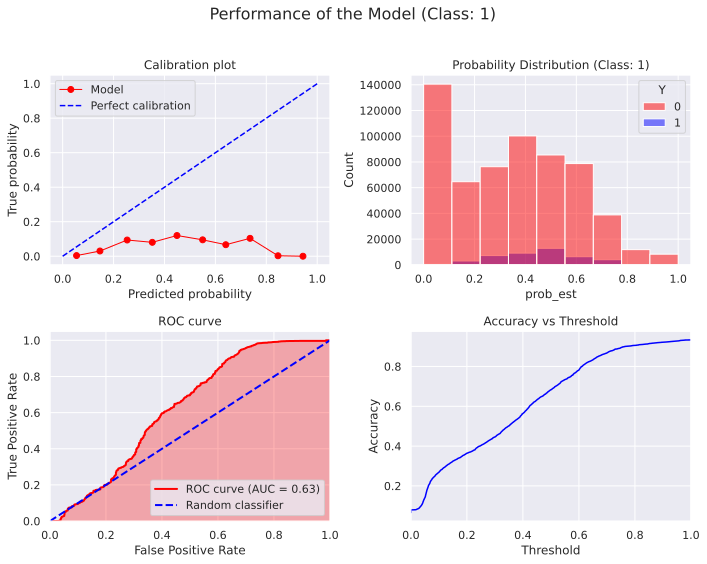

In [28]:
plotClassPerformance(dfTS_eval_pca['Y'], xgb_fit_pca.predict_proba(X_test_pca[INPUTS_XGB]), selClass=1)

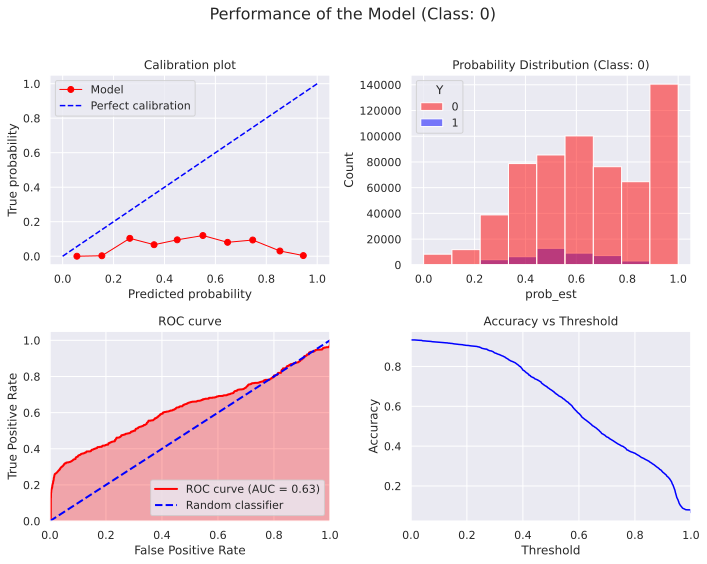

In [29]:
plotClassPerformance(dfTS_eval_pca['Y'], xgb_fit_pca.predict_proba(X_test_pca[INPUTS_XGB]), selClass=0)

In [ ]:
•